In [1]:
#https://blogs.oracle.com/datascience/fraud-detection-using-autoencoders-in-keras-with-a-tensorflow-backend

%run -i start_spark.py --master local[*] --driver-memory 2g
#%run -i start_spark.py --master local[2] spark://192.168.0.100:7077

Creating SparkContext...
SparkContext created.
Master URL: local[*]


**Do not forget to close the session with spark.stop()**

# Fraud detection using a deep learning binary classifier

In the following a supervised deep learning (DL) algorithm will be tested to select a model for the fraud detection. The model implements perceptron with a fully connected neural network. As the data is higly inbalanced, more algorithms will be used to maximize the performances.

The model offered good performance and is capable to identify 1915 true positives over 2482 of the test set with just 669 false positives. The model resulted the best performer among the models tested, followed by the Random Forest. For the scope of the Capstone project, this model is selected for the deployment. Future work can consider to use multiple models and weight the results to increase the number of true positives.

In [2]:
%matplotlib inline

import coursera_common as cc
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Input
from keras import regularizers
from keras.callbacks import TensorBoard, ModelCheckpoint

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import precision_recall_curve, confusion_matrix
from sklearn.metrics import recall_score, classification_report, auc, roc_curve

Using TensorFlow backend.


As the model is implemented in Keras, the parquet dataframe is cached as numpy array. As for the previous models, it can be considered to train the model in a spark cluster. 

In [3]:
REBUILD_CACHE = False
SAMPLE = 1

if REBUILD_CACHE \
    or not os.path.exists( cc.AUTOENC_X_TRAIN ) \
    or not os.path.exists( cc.AUTOENC_Y_TRAIN ) \
    or not os.path.exists( cc.AUTOENC_X_TEST ) \
    or not os.path.exists( cc.AUTOENC_Y_TEST ):

    print('Rebuilding cache')
    #Writing payments to parquet
    payments_enc = cc.readParquet(spark, cc.PAYMENTS_ENC_PQT_FILENAME)
    payments_enc.show(5)

    # split train and test df
    print('Split train and test...')

    if SAMPLE < 1:
        train_df, test_df = payments_enc.select(['featuresIndexed', 'isFraud']).sample(fraction=SAMPLE).randomSplit([0.7, 0.3], seed = cc.RANDOM_SEED)
    else:
        train_df, test_df = payments_enc.select(['featuresIndexed', 'isFraud']).randomSplit([0.7, 0.3], seed = cc.RANDOM_SEED)

    print('Training dataset count: {}'.format(train_df.count()))
    print('Test Dataset Count: {}'.format(test_df.count()))

    print('Train # normal: {}'.format(train_df.where(train_df.isFraud==0).count()))
    print('Train # isFraud: {}'.format(train_df.where(train_df.isFraud==1).count()))

    print('Test # normal: {}'.format(test_df.where(test_df.isFraud==0).count()))
    print('Test # isFraud: {}'.format(test_df.where(test_df.isFraud==1).count()))
else:
    print('Load data sets from cache.')

Load data sets from cache.


In [4]:
scaler = StandardScaler()

####### TRAIN
if not REBUILD_CACHE and os.path.exists( cc.AUTOENC_X_TRAIN ):
    print('Loading ' + cc.AUTOENC_X_TRAIN)
    x_train = np.load( cc.AUTOENC_X_TRAIN )
else:
    print('Extracting x_train features as array...')
    x_train = np.array(train_df.select('featuresIndexed').collect())
    x_train = np.apply_along_axis(lambda x : x[0], 1, x_train)
    x_train = scaler.fit_transform(x_train)

    print('Saving ' + cc.AUTOENC_X_TRAIN)
    np.save(cc.AUTOENC_X_TRAIN, x_train)
    print('Complete!')

if not REBUILD_CACHE and os.path.exists( cc.AUTOENC_Y_TRAIN ):
    print('Loading ' + cc.AUTOENC_Y_TRAIN)
    y_train = np.load( cc.AUTOENC_Y_TRAIN )
else:
    print('Extracting y_train features as array...')
    y_train = np.array(train_df.select('isFraud').collect())
    y_train = np.apply_along_axis(lambda x : x[0], 1, y_train)

    print('Saving ' + cc.AUTOENC_Y_TRAIN)
    np.save(cc.AUTOENC_Y_TRAIN, y_train)
    print('Complete!')

####### TEST
if not REBUILD_CACHE and os.path.exists( cc.AUTOENC_X_TEST ):
    print('Loading ' + cc.AUTOENC_X_TEST)
    x_test = np.load( cc.AUTOENC_X_TEST )
else:
    print('Extracting Test features as array...')
    x_test = np.array(test_df.select('featuresIndexed').collect())
    x_test = np.apply_along_axis(lambda x : x[0], 1, x_test)
    x_test = scaler.fit_transform(x_test)

    print('Saving ' + cc.AUTOENC_X_TEST)
    np.save(cc.AUTOENC_X_TEST, x_test)
    print('Complete!')

if not REBUILD_CACHE and os.path.exists( cc.AUTOENC_Y_TEST ):
    print('Loading ' + cc.AUTOENC_Y_TEST)
    y_test = np.load( cc.AUTOENC_Y_TEST )
else:
    y_test = np.array(test_df.select('isFraud').collect())
    y_test = np.apply_along_axis(lambda x : x[0], 1, y_test)
    print('Complete!')

    print('Saving ' + cc.AUTOENC_Y_TEST)
    np.save(cc.AUTOENC_Y_TEST, y_test)
    print('Complete!')

print('Complete!')

Loading data/autoencoder.x_train.v2.npy
Loading data/autoencoder.y_train.v2.npy
Loading data/autoencoder.x_test.v2.npy
Loading data/autoencoder.y_test.v2.npy
Complete!


A sample of 3000 transactions is selected to plot the data. Dimensions are reduced via PCA.

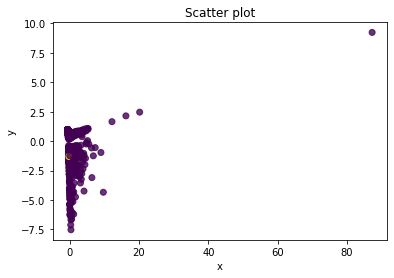

In [5]:
pca_idx = np.random.choice(x_train.shape[0], 3000, replace=False)  

pca = PCA(2)
x_pca = pca.fit_transform(x_train[pca_idx])
x_pca = pd.DataFrame(x_pca)
x_pca.columns=['PC1','PC2']

# Plot
import matplotlib.pyplot as plt
plt.scatter(x_pca['PC1'], x_pca['PC2'], c=y_train[pca_idx], alpha=0.8)
plt.title('Scatter plot')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [6]:
nb_epoch = 50
batch_size = 256

input_dim = x_train.shape[1]
encoding_dim = 5
hidden_dim = 3  

learning_rate = 0 #1e-5

# Guarantee reproducible results
cc.set_random_seed(cc.RANDOM_SEED)

input_layer = Input(shape=(input_dim, ))

if learning_rate == 0:
    encoder = Dense(encoding_dim, activation="tanh")(input_layer)
else:
    encoder = Dense(encoding_dim, activation="tanh", activity_regularizer=regularizers.l1(learning_rate))(input_layer)

encoder = Dense(hidden_dim, activation='relu')(encoder)
#encoder = Dense(2, activation='tanh')(encoder)
decoder = Dense(hidden_dim, activation='relu')(encoder)
decoder = Dense(encoding_dim, activation='relu')(encoder)
decoder = Dense(1, activation='sigmoid')(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)

print(autoencoder.summary())

autoencoder.compile(metrics=['accuracy'], loss='binary_crossentropy', optimizer='adam')

#cp = ModelCheckpoint(filepath="autoencoder_fraud.h5", save_best_only=True, verbose=5)

#tb = TensorBoard(log_dir='logs/', histogram_freq=0, write_graph=True, write_images=True)

history = autoencoder.fit(x_train, y_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(x_test, y_test),
                    verbose=1 #,
                    #callbacks=[cp, tb]
                    ).history




_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 6)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 35        
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 18        
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 20        
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 6         
Total params: 79
Trainable params: 79
Non-trainable params: 0
_________________________________________________________________
None


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 4454158 samples, validate on 190

In [7]:
MODEL_KEY = 'v1'

autoencoder.save('models/perceptron.{}.h5'.format(MODEL_KEY))

#Save configuration
json_config = autoencoder.to_json()
with open('models/perceptron.{}.json'.format(MODEL_KEY), 'w') as json_file:
    json_file.write(json_config)

autoencoder.save_weights('models/perceptron_weights.{}.json'.format(MODEL_KEY))

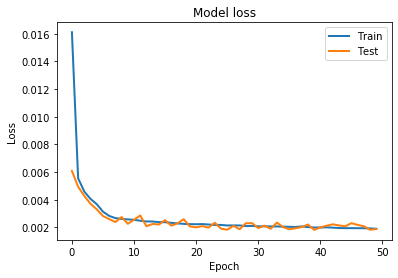

In [8]:
# Model Loss
plt.plot(history['loss'], linewidth=2, label='Train')
plt.plot(history['val_loss'], linewidth=2, label='Test')
plt.legend(loc='upper right')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
#plt.ylim(ymin=0.70,ymax=1)
plt.show()

Evaluate model both on train and test dataset to observe differences, if any, due to the data balance.

In [10]:
eval_model = autoencoder.evaluate(x_train, y_train)
eval_model

4454158/4454158 [==============================] - 84s 19us/step


[0.0019338517129437933, 0.9994438904053247]

In [11]:
eval_model = autoencoder.evaluate(x_test, y_test)
eval_model

1908462/1908462 [==============================] - 40s 21us/step


[0.001882612304155493, 0.9994529626474092]

The performance of the model on the two dataset is comparable.

In [9]:
y_pred = autoencoder.predict(x_test)

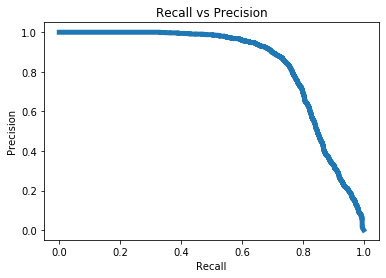

In [25]:
precision_rt, recall_rt, threshold_rt = precision_recall_curve(y_test, y_pred)
plt.plot(recall_rt, precision_rt, linewidth=5, label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

A threshold can be select by evaluating the precision and recall for different values. A value around 0.4 is a good trade off between precision and recall. For a value of 0.35 the number of true positives is 1952 vs 686 false negatives.

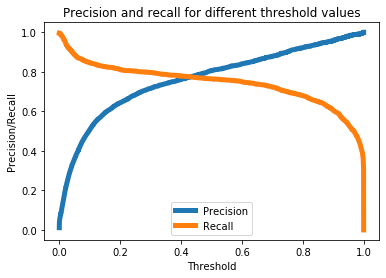

In [26]:
plt.plot(threshold_rt, precision_rt[1:], label="Precision",linewidth=5)
plt.plot(threshold_rt, recall_rt[1:], label="Recall",linewidth=5)
#plt.xticks(np.arange(min(threshold_rt), max(threshold_rt)+1, 0.002))
plt.title('Precision and recall for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

Confusion matrix, without normalization
[[1905294     686]
 [    530    1952]]


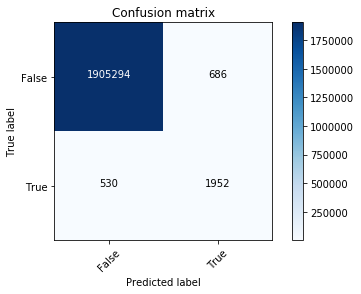

In [21]:
threshold = 0.35
y_pred_t = (y_pred > threshold)
conf_matrix = confusion_matrix(y_test, y_pred_t)

cc.plot_confusion_matrix(conf_matrix, classes=['False','True'], normalize=False)

A business decision is needed in order to identify a proper threshold. Given that the data is highly unbalanced, a lower threshold can be considered. For the business case subject of this study, a lower threshold can be acceptable even if the number of false positive increases. Whether in general a precision of 50% is not acceptable, in this specific case it can still be accepted in order to minimize the potential loss. A threshold of 0.1 provides such kind of trade off. For lower thresholds the recall will increase quickly, leading to a very high amount of false positive. That is also not desider.

Confusion matrix, without normalization
[[1903931    2049]
 [    382    2100]]


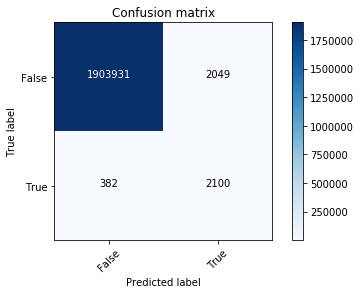

In [24]:
threshold = 0.1
y_pred_t = (y_pred > threshold)
conf_matrix = confusion_matrix(y_test, y_pred_t)

cc.plot_confusion_matrix(conf_matrix, classes=['False','True'], normalize=False)

In [17]:
# Retrain the moddel on the whole dataset

try:
    payments_enc
except:
    print('Rebuilding cache')
    #Writing payments to parquet
    payments_enc = cc.readParquet(spark, cc.PAYMENTS_ENC_PQT_FILENAME)

if not REBUILD_CACHE and os.path.exists( cc.AUTOENC_X_ALL ):
    print('Loading ' + cc.AUTOENC_X_ALL)
    x_train = np.load( cc.AUTOENC_X_ALL )
else:
    print('Extracting x_train features as array...')
    x_train = np.array(payments_enc.select('featuresIndexed').collect())
    x_train = np.apply_along_axis(lambda x : x[0], 1, x_train)
    x_train = scaler.fit_transform(x_train)

    print('Saving ' + cc.AUTOENC_X_ALL)
    np.save(cc.AUTOENC_X_ALL, x_train)
    print('Complete!')

if not REBUILD_CACHE and os.path.exists( cc.AUTOENC_Y_ALL ):
    print('Loading ' + cc.AUTOENC_Y_ALL)
    y_train = np.load( cc.AUTOENC_Y_ALL )
else:
    print('Extracting y_train features as array...')
    y_train = np.array(payments_enc.select('isFraud').collect())
    y_train = np.apply_along_axis(lambda x : x[0], 1, y_train)

    print('Saving ' + cc.AUTOENC_Y_ALL)
    np.save(cc.AUTOENC_Y_ALL, y_train)
    print('Complete!')

Rebuilding cache
Restoring data/payments_enc.v6.parquet...
Complete!
Extracting x_train features as array...
Saving data/autoencoder.x_all.v2.npy
Complete!
Extracting y_train features as array...
Saving data/autoencoder.y_all.v2.npy
Complete!


In [18]:
history = autoencoder.fit(x_train, y_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(x_test, y_test),
                    verbose=1 #,
                    #callbacks=[cp, tb]
                    ).history

Train on 6362620 samples, validate on 1908462 samples
Epoch 1/50
6362620/6362620 [==============================] - 48s 7us/step - loss: 0.0019 - acc: 0.9995 - val_loss: 0.0018 - val_acc: 0.9994
Epoch 2/50
6362620/6362620 [==============================] - 48s 8us/step - loss: 0.0019 - acc: 0.9995 - val_loss: 0.0021 - val_acc: 0.9994
Epoch 3/50
6362620/6362620 [==============================] - 44s 7us/step - loss: 0.0019 - acc: 0.9995 - val_loss: 0.0018 - val_acc: 0.9994
Epoch 4/50
6362620/6362620 [==============================] - 40s 6us/step - loss: 0.0019 - acc: 0.9995 - val_loss: 0.0018 - val_acc: 0.9994
Epoch 5/50
6362620/6362620 [==============================] - 43s 7us/step - loss: 0.0019 - acc: 0.9995 - val_loss: 0.0016 - val_acc: 0.9995
Epoch 6/50
6362620/6362620 [==============================] - 44s 7us/step - loss: 0.0019 - acc: 0.9995 - val_loss: 0.0017 - val_acc: 0.9995
Epoch 7/50
6362620/6362620 [==============================] - 48s 8us/step - loss: 0.0018 - acc: 0.9

In [19]:
MODEL_KEY = 'all.v1'

autoencoder.save('models/perceptron.{}.h5'.format(MODEL_KEY))

#Save configuration
json_config = autoencoder.to_json()
with open('models/perceptron.{}.json'.format(MODEL_KEY), 'w') as json_file:
    json_file.write(json_config)

autoencoder.save_weights('models/perceptron_weights.{}.json'.format(MODEL_KEY))

See deployment at https://dataplatform.cloud.ibm.com/exchange/public/entry/view/50fa9246181026cd7ae2a5bc7e4ac7bd

You can deploy a Decision Optimization model, create and monitor jobs, and get solutions using the Watson Machine Learning Python Client. For more information, see Watson Machine Learning Python client documentation (https://wml-api-pyclient-dev-v4.mybluemix.net/#deployments).

The Python notebook Deploying a Decision Optimization model in Watson Machine Learning, available from the IBM Watson Studio Gallery, illustrates how to perform the following tasks: